Code for the paper "Understanding Filter Bubbles and Polarization in Social Networks" by Uthsav Chitra and Chris Musco.

Link: https://arxiv.org/pdf/1906.08772.pdf


All code is run using Python 3.
Dependencies: 
* Numpy version 1.16.3
* Matplotlib version 3.0.3
* Scipy version 1.2.1
* NetworkX version 2.3
* Gurobi version 8.1.1 [Note: Gurobi needs a license to be run, but this license is free for academics]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from scipy.linalg import solve

from gurobipy import *

import networkx as nx

from time import time
from pprint import pprint
import pickle
import csv # reading network files

# Alternating Minimization/SBM Code

Below: code for generating a Stochastic Block Model (SBM) graph with two groups (Section 4.1)

In [2]:
# q0: edge probability in group 0
# q1: edge probability in group 1
# p: edge probability in between groups

# intrinsic opinions in group i are drawn iid from N(si_mean, s_std)
# group 0 has n nodes, group 1 has m nodes
def create_A_s(q0,q1,p, s0_mean=0.25, s1_mean=0.75, s_std=0.1,n=32,m=32,lb=0,ub=1):
    tot = n+m

    A = np.zeros([tot,tot])
    for i in range(tot):
        for j in range(i+1,tot):
            if i > n and j > n: #q1
                A[i,j]=np.random.binomial(1,q1)
            elif j > n: # then i <=n-1 and j > n, so p
                A[i,j]=np.random.binomial(1,p)
            elif j <=n: # then i <= n-1 and j <= n-1, so q0
                A[i,j]=np.random.binomial(1,q0)
    A=A+A.T
    s = np.concatenate((np.random.normal(loc=s0_mean,scale=s_std,size=n),np.random.normal(loc=s1_mean,scale=s_std,size=m)))
    s=np.maximum(s,lb)
    s=np.minimum(s,ub)
    return A,s

Next, we create our "alternating minimization" function, which simulates the Network Administrator Dynamics (Section 3)

In [3]:
################################################
# HELPER FUNCTIONS FOR ALTERNATING MINIMIZATION
################################################

# find z that minimizes z^T L z + |z-s|^2　？？？？
# W = weight matrix for graph
# s = innate opinions
def min_z(W,s):
    D = np.diag(np.sum(W,0))
    L = D - W
    n=L.shape[0]
    return solve(L+np.eye(n),s)
# scipy.linalgのsolveはAx=Bを解く

# find weight matrix W that minimizes z^T L z, 
# where L is graph Laplacian corresponding to W
# constrained to {W : ||W-W0|| < lam * ||W0||} where W0 is the original graph
# (lam is what proportio of edges in the original graph you are allowed to change)
# we also impose the restriction that sum(W[:,i]) = sum(W0[:,i]), 
# i.e. the degree of each vertex is conserved

# IF reduce_pls = True, then we add the term gam*||W||^2 to the objective
# as this empirically reduces polarization (encourages more connections to every vertex)
def min_w_gurobi(z, lam, W0, reduce_pls, gam, existing):
    n = z.shape[0]
    m = Model("qcp")
    m.setParam('OutputFlag', 0)
    print('the number of n: ', n)

    if existing:
        inds = [(i,j) for i in range(n) for j in range(n) if i>j and W0[i,j] > 0]
    else:
        # (i, j)というセットのうち、範囲の中にあって、かつi>jとなるセットをindsに保存
        inds = [(i,j) for i in range(n) for j in range(n) if i>j]
    x=m.addVars(inds, lb=0.0, name="x")
    print('the length of x: ', len(x))

    # obj is min \sum_{i,j} wij (zi-zj)^2
    if existing:
        w={(i,j):(z[i]-z[j])**2 for i in range(n) for j in range(n) if i>j and W0[i,j]>0}
    else:
        # 範囲の中にあってかつi>jである(i,j)をキーとして、zi-zjの差の二乗をValueとして保存
        w = {(i,j):(z[i]-z[j])**2 for i in range(n) for j in range(n) if i>j}

    # 先ほど作成したzi-zjにそれぞれxijをかける。xijは新しいwijとなるもの
    obj_exp = x.prod(w)
    if reduce_pls:
        obj_exp += gam*x.prod(x)
    m.setObjective(obj_exp, GRB.MINIMIZE)
    print('added variables')
    
    # add constraints sum_j x[i,j] = di
    d = np.sum(W0,0) #縦方向、列ごとに足し合わせる
    for i in range(n):
        if existing:
            m.addConstr(quicksum([x[(j,i)] for j in range(i+1,n) if W0[i,j] > 0] + [x[(i,j)] for j in range(i) if W0[i,j] > 0]) == d[i])
        else:
            m.addConstr(quicksum([x[(j,i)] for j in range(i+1,n)] + [x[(i,j)] for j in range(i)]) == d[i])
            #range関数を見れば必然的にj>iである
            #本来なら行列のx(i,j)を全部行ごと足したいけれど、下三角行列だから、反対側は、x(j,i)で探すしかないってこと。
    print('added first constraint')
    
    # add constraint \sum_{i,j} (wij - w0ij) < lam*norm(w0)**2
    rhs = (lam*np.linalg.norm(A))**2
    
    if existing:
        m.addQConstr(quicksum([x[(i,j)]*x[(i,j)]-2*x[(i,j)]*W0[i,j]+W0[i,j]*W0[i,j] for i in range(n) for j in range(n) if i>j and W0[i,j] > 0]) <= rhs)
    else:
        m.addQConstr(quicksum([x[(i,j)]*x[(i,j)]-2*x[(i,j)]*W0[i,j]+W0[i,j]*W0[i,j] for i in range(n) for j in range(n) if i>j]) <= rhs)
    print('added second constraint')
    print('starting to optimize')
    m.optimize()
    
    W = np.zeros([n,n])
    for u in range(n):
        for v in range(n):
            if u>v:
                if (existing and W0[u,v] > 0) or (not existing):
                    W[u,v]=x[(u,v)].X
                    W[v,u] = W[u,v]
    return W

# given opinion vectors z, compute 
# polarization = variance(z)
def compute_pls(z):
    z_centered = z - np.mean(z)
    return z_centered.dot(z_centered)

In [10]:
# Alternating Minimization function for network admin game
# Parameters:
# 1) A: initial graph (adjacency matrix) 

# 2) s: intrinsic opinions

# 3) lam: constraint parameter

# 4) reduce_pls: if true, implement additional L2 regularization to 
# reduce polarization (and disagreement!)
# 5) gam: regularization coefficient for reduce_pls
# 6) max_iters: max number of iterations of network admin game

# 7) existing: only change weights of edges already existing in the graph 

# RETURNS:
# pls: list of polarizations at each iteration
# z: opinions at final iteration of game
# W: adjacency matrix at final iteration of game
def am(A,s,lam,reduce_pls=False,gam=0,max_iters=100, existing=False):
    # alternating minimization
    W = np.copy(A)
    z = min_z(W,s) # minimize z first // 最初にFJモデルに従って各ユーザが自分の意見を変える

    # polarization
    pls = [compute_pls(z)]
    
    # disagreement
    L = np.diag(np.sum(W,0))-W
    disaggs = [z.T.dot(L).dot(z)]

    # LOOP: first minimize W, then minimize z
    # then decide if we should exit
    i = 0
    flag = True
    while flag:
        print('iteration: {}'.format(i))
        # minimize W
        Wnew = min_w_gurobi(z,lam,A,reduce_pls=reduce_pls,gam=gam,existing=existing)
        # Wは使わないの？
        
        np.set_printoptions(precision=2, suppress=True)
        print('W after Admin effect:\n ', Wnew)
        
        # minimize z
        znew = min_z(Wnew,s)
        print('Z after FJ model: \n', znew)
        print('z-znew: \n', np.linalg.norm(z-znew))
        print('W-Wnew\n', np.linalg.norm(Wnew-W))

        # exit condition
        if np.maximum(np.linalg.norm(z-znew), np.linalg.norm(Wnew-W)) < 5e-1 or i > max_iters - 1:
            # W, zの前後の距離が十分小さいなら、（収束したと見做せる）なら、終了
            flag = False

        # update z,W,i,pls
        z = znew
        W = Wnew
        i=i+1
        pls.append(compute_pls(z))
        L = np.diag(np.sum(W,0))-W
        disaggs.append(z.T.dot(L).dot(z))
    return pls, disaggs, z, W

# Creating Teaser Image (Figure 1)

In this section, we create the images used in Figure 1.
Note: If you re-run this code, you will likely create an image that looks different than Figure 1, because of the randomness in the SBM graph (and also I'm not sure how networkx draws graphs).

## Create SBM network and run NA dynamics

In [5]:
q0=0.25
q1=0.25
p=0.1
n=20
m=20

# create SBM network
A,s=create_A_s(q0,q1,p, s0_mean=-0.7, s1_mean=0.7, s_std=0.1,n=n,m=m,lb=-1.0,ub=1.0)

# run the network administrator (NA) dynamics on A, 
# with varying amounts of constraints on NA
pls1,objs1,z1,W1=am(A,s,0.14)
pls2,objs2,z2,W2=am(A,s,0.2)
pls3,objs3,z3,W3=am(A,s,0.3) # ended up not using this one

W1=np.round(W1,decimals=3)
W2=np.round(W2,decimals=3)
W3=np.round(W3,decimals=3)

LA = np.diag(np.sum(A,0))-A
z_before=solve(LA+np.eye(n+m),s)

iteration: 0
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-24
added variables
added first constraint
added second constraint
starting to optimize
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 40 rows, 780 columns and 1560 nonzeros
Model fingerprint: 0x125659a0
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-08, 5e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
  QRHS range       [1e+02, 1e+02]
Presolve time: 0.00s
Presolved: 822 rows, 782 columns, 2465 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 3.374e+05
 Factor NZ  : 3.383e+05 (roughly 3 MB of memory)
 

## Functions for graph visualization

A bunch of scripts for visualizing our graphs so that:

1) edges are lighter/darker depending on their weight

2) nodes are colored depending on their expressed opinion

In [6]:
def vis_params(W,z,layout='spring'):
    G = nx.Graph(W)
    
    if layout == 'spectral':
        pos=nx.spectral_layout(G)
    else:
        pos = nx.spring_layout(G)
        
    edge_colors = np.zeros(len(G.edges))
    i=0
    for edge in G.edges():
        u,v=edge
        edge_colors[i]=W[u,v]
        i+=1

    node_colors = np.zeros(len(G.nodes))
    i=0
    for n in G.nodes():
        node_colors[i]=z[i]
        i+=1
    return G, pos, edge_colors, node_colors

def plot_graph(G, pos, node_colors, edge_colors, emin, emax, vmin, vmax,width=0.5,node_size=150):
    nx.draw(G, pos, node_size=node_size, node_color=node_colors, cmap=plt.cm.coolwarm, vmin=vmin,vmax=vmax, width=width, edge_color=edge_colors, edge_cmap=plt.cm.binary, edge_vmin=emin, edge_vmax=emax)

Ga, posa, edge_colors_a, node_colors_a = vis_params(A, z_before)
G1, pos1, edge_colors_1, node_colors_1 = vis_params(W1, z1)
G2, pos2, edge_colors_2, node_colors_2 = vis_params(W2, z2)
G3, pos3, edge_colors_3, node_colors_3 = vis_params(W3, z3)

# set scale for edges
# we want weight emax to be the darkest edge, and 0.0 to be the lightest edge
emin=0.2
emax=1.0

# set scale for vertices
# we want 1.0 to be reddest vertex, 0.0 to be bluest vertex
vmin1=-1.0
vmax1=1.0

vmin2=np.min(z2)
vmax2=np.max(z2)

## Check how much NA changed graphs

Check what % of edge weight in W1 and W2 is changed by the NA

In [7]:
np.linalg.norm(W1-A,1) /np.linalg.norm(A,1) # about 20% is changed

0.2174166666666667

In [8]:
np.linalg.norm(W2-A,1) /np.linalg.norm(A,1) # about 30% is changed

0.31024999999999997

## Create plots used in teaser figure 

In [9]:
plot_graph(Ga, pos, node_colors_a, edge_colors_a, emin, emax, vmin1, vmax1,node_size=100)
plt.savefig('potential_teaser4a_2.pdf')

NameError: name 'pos' is not defined

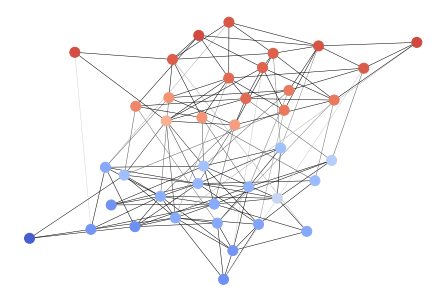

In [260]:
plot_graph(G1, pos, node_colors_1, edge_colors_1, emin, emax, vmin2, vmax2,node_size=100)
plt.savefig('potential_teaser4b_2.pdf')

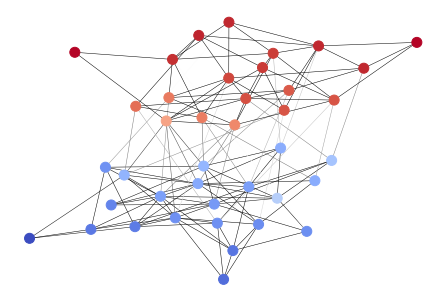

In [261]:
plot_graph(G2, pos, node_colors_2, edge_colors_2, emin, emax, vmin2, vmax2,node_size=100)
plt.savefig('potential_teaser4c_2.pdf')

# Working with real networks (Figure 2, Figure 4)

Below is the code for Figure 2 and Figure 4 in the paper. For two networks (Reddit and Twitter) we run:

1) Network Administrator Dynamics (Section 3)    
2) Regularized Network Administrator Dynamics (Section 5)

For details on the datasets, see Section 3.2.

## Reddit

### Load network, opinions

In [11]:
# load adjacency matrix
n_reddit=556
A = np.zeros([n_reddit, n_reddit])
z_dict={i:[] for i in range(n_reddit)}

with open('Random/edges_random.txt','r') as f:
    reader=csv.reader(f,delimiter='\t')
    for line in reader:
        if len(line) == 2: 
            u,v = line
            A[int(u)-1,int(v)-1] += 1
            A[int(v)-1,int(u)-1] += 1
        else:
            print(f"Skipping line: {line}") 

# load opinions
with open('Random/random_opinion.txt','r') as f:
    reader=csv.reader(f,delimiter='\t')
    for u,v,w in reader:
        z_dict[int(u)-1].append(float(w))

# remove nodes not connected in graph
not_connected = np.argwhere(np.sum(A,0)==0)
A=np.delete(A,not_connected,axis=0)
A=np.delete(A,not_connected,axis=1)
n_reddit = n_reddit-len(not_connected)

# create z (avg-ing posts)
z = [np.mean(z_dict[i]) for i in range(n_reddit)]
z=np.array(z)
print('z: \n', z)

# create innate opinions from z (i.e. s=(L+I)*z)
L = np.diag(np.sum(A,0)) - A
s = (L+np.eye(n_reddit)).dot(z)
s=np.minimum(np.maximum(s,0),1)
print('s: \n', s)


z: 
 [0.2 0.6 0.8 0.3 0.4 0.1 0.9 0.7 0.1 0.4 0.3 0.7 0.7 0.3 0.5]
s: 
 [0.  1.  1.  0.4 0.  0.  1.  1.  0.  0.3 0.  1.  1.  0.  1. ]


### Run NA dynamics

We run the Network Administrator Dynamics on the Reddit network, both non-regularized (Section 3) and regularized (Section 5).    
NOTE: running the below code will take a couple hours. Be sure to save the results!

In [12]:
# run NA dynamics for lam=[0.1,0.2, ..., 1.0]
# because of time issues, we run the NA dynamics separately 
# for [0.1, ..., 0.5] and [0.6, ..., 1.0]

lam_list = [0.1,0.2,0.3,0.4,0.5]
# results are dicts of the form
# lambda -> (polarization at each iteration, disagreement at each iter, expressed opinions after NA dynamics, adjacency matrix after NA dynamics)

rd={} # results for NA dynamics
rd_fix={} # results for regularized NA dynamics

max_iter=7 # usually converges after 5-10 iterations
gam=0.2 # L2 regularization coefficient
for lam in lam_list:
    print('no fix')
    print('lam: {}'.format(lam))
    pls, disaggs, z, W = am(A,s,lam,reduce_pls=False,gam=0,max_iters=max_iter)
    print('pls: \n', pls)
    print('disagg: \n', disaggs)
    '''print('with fix')
    print('lam: {}'.format(lam))
    pls2, disaggs2, z2, W2 = am(A,s,lam,reduce_pls=True,gam=gam,max_iters=max_iter)
    '''
    rd[lam] = (pls,disaggs,z,W)
    #rd_fix[lam] = (pls2,disaggs2,z2,W2)


"""
#### Zが合っているか確認
import pandas as pd 
WW = pd.read_csv('Z.csv', header=None)
WW = WW.to_numpy()
ZZ = min_z(WW, s)
print('ZZ', ZZ)
"""

no fix
lam: 0.1
iteration: 0
the number of n:  15
the length of x:  105
added variables
added first constraint
added second constraint
starting to optimize
W after Admin effect:
  [[0.   0.   0.   0.   1.06 0.06 0.73 0.   1.08 0.03 1.06 0.   0.   1.06
  0.9 ]
 [0.   0.   1.05 0.   0.87 0.   1.06 0.05 0.   0.   0.87 0.07 0.06 0.91
  1.06]
 [0.   1.05 0.   0.   0.78 0.85 0.07 0.06 0.   0.   0.   0.08 1.08 0.
  0.04]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.02 0.97 0.   0.   0.   0.
  0.  ]
 [1.06 0.87 0.78 0.   0.   0.07 0.   0.   0.07 1.04 0.06 0.   0.   0.08
  0.96]
 [0.06 0.   0.85 0.   0.07 0.   0.   0.87 0.07 0.05 1.07 0.87 0.   0.09
  0.01]
 [0.73 1.06 0.07 0.   0.   0.   0.   0.06 0.   0.   0.   1.08 0.08 0.85
  0.05]
 [0.   0.05 0.06 0.   0.   0.87 0.06 0.   0.   0.   0.8  0.07 0.07 0.
  1.04]
 [1.08 0.   0.   1.02 0.07 0.07 0.   0.   0.   0.04 0.07 0.69 0.   0.07
  0.89]
 [0.03 0.   0.   0.97 1.04 0.05 0.   0.   0.04 0.   1.04 0.   0.77 0.05
  0.  ]
 [1.06 0.87 0.   0.   0.06

"\n#### Zが合っているか確認\nimport pandas as pd \nWW = pd.read_csv('Z.csv', header=None)\nWW = WW.to_numpy()\nZZ = min_z(WW, s)\nprint('ZZ', ZZ)\n"

In [ ]:
lam_list = [0.6,0.7,0.8,0.9,1.0]
rd_large={}
rd_large_fix={}

max_iter=7
gam=0.2
for lam in lam_list:
    print('no fix')
    print('lam: {}'.format(lam))
    pls, disaggs, z, W = am(A,s,lam,reduce_pls=False,gam=0,max_iters=max_iter)
    print('with fix')
    print('lam: {}'.format(lam))
    pls2, disaggs2, z2, W2 = am(A,s,lam,reduce_pls=True,gam=gam,max_iters=max_iter)
    
    rd_large[lam] = (pls,disaggs,z,W)
    rd_large_fix[lam] = (pls2,disaggs2,z2,W2)

### Analyze results

Below: an example entry of the results

In [8]:
rd[0.5]

([0.11935838533454612,
  1.0195340986504553,
  1.0775788657212304,
  1.0945226823890044],
 [0.4690899219103976,
  0.7491608443613081,
  0.7364846735361374,
  0.7280369455230363],
 array([0.25, 0.74, 0.84, 0.31, 0.29, 0.22, 0.84, 0.79, 0.25, 0.29, 0.29,
        0.86, 0.86, 0.23, 0.62]),
 array([[0.  , 0.  , 0.  , 0.  , 1.22, 0.41, 0.  , 0.  , 1.15, 0.08, 1.21,
         0.  , 0.  , 1.37, 0.55],
        [0.  , 0.  , 1.34, 0.  , 0.35, 0.  , 1.34, 0.34, 0.  , 0.  , 0.32,
         0.34, 0.34, 0.27, 1.35],
        [0.  , 1.34, 0.  , 0.  , 0.  , 0.  , 0.37, 0.32, 0.  , 0.  , 0.  ,
         0.38, 1.38, 0.  , 0.2 ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.  , 0.9 , 0.84, 0.  ,
         0.  , 0.  , 0.11, 0.  ],
        [1.22, 0.35, 0.  , 0.  , 0.  , 0.49, 0.  , 0.  , 0.24, 1.17, 0.31,
         0.  , 0.  , 0.45, 0.77],
        [0.41, 0.  , 0.  , 0.15, 0.49, 0.  , 0.  , 0.03, 0.43, 0.35, 1.48,
         0.  , 0.  , 0.65, 0.  ],
        [0.  , 1.34, 0.37, 0.  , 0.  , 0.  , 0.  , 0.32, 0.

#### Plot polarization, disagreement without regularization

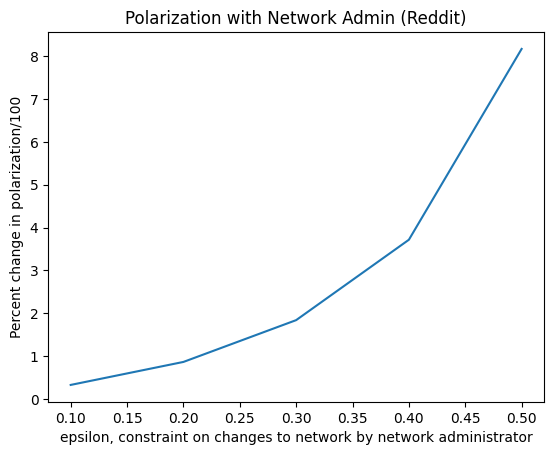

In [10]:
lam1vals=[0.1,0.2,0.3,0.4,0.5]
#lam2vals=[0.6,0.7,0.8,0.9,1.0]

lamvals=lam1vals
#+lam2vals

pls_after_list = np.zeros(len(lamvals))
pls_ratio_list = np.zeros(len(lamvals))
i=0
for lam in lamvals:
    if lam <= 0.5:
        pls = rd[lam][0]
    else:
        pls = rd_large[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    pls_after_list[i] = pls[-1]
    i+=1

#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
#plt.rcParams.update({'font.size': 13})


plt.plot(lamvals,pls_ratio_list - 1)
plt.xlabel('epsilon, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization/100')
plt.title('Polarization with Network Admin (Reddit)')

plt.savefig('polarization_reddit.pdf')

# HUGE increase in polarization

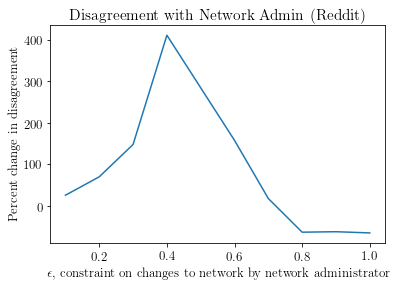

In [287]:
lam1vals=[0.1,0.2,0.3,0.4,0.5]
lam2vals=[0.6,0.7,0.8,0.9,1.0]

lamvals=lam1vals+lam2vals

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    if lam <= 0.5:
        dis = rd[lam][1]
    else:
        dis = rd_large[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list - 1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title('Disagreement with Network Admin (Reddit)')

plt.savefig('disagreement_reddit.pdf')

# wow, disagreement increases a lot too!

#### Plot polarization, disagreement with regularization

In [1]:
# same plots, but with regularized NA dynamics
lam1vals=[0.1,0.2,0.3,0.4,0.5]
lam2vals=[0.6,0.7,0.8,0.9,1.0]

lamvals=lam1vals
#+lam2vals

pls_after_list=np.zeros(len(lamvals))
pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    if lam <= 0.5:
        pls = rd_fix[lam][0]
    #else:
    #    pls = rd_fix_large[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    pls_after_list[i] = pls[-1]
    i+=1

#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
#plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(pls_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization')
plt.title('Polarization with Regularized Network Admin (Reddit)')
    
plt.savefig('polarization_reddit_fix.pdf')

# polarization is mostly neutral (even slightly dips at lambda=0.2,0.3)

NameError: name 'np' is not defined

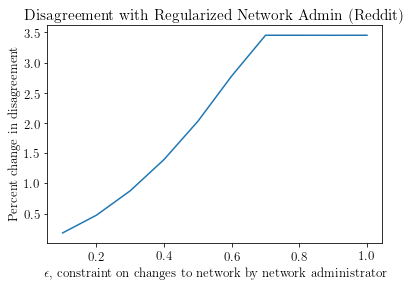

In [289]:
lam1vals=[0.1,0.2,0.3,0.4,0.5]
lam2vals=[0.6,0.7,0.8,0.9,1.0]

lamvals=lam1vals+lam2vals

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    if lam <= 0.5:
        dis = rd_fix[lam][1]
    else:
        dis = rd_fix_large[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title('Disagreement with Regularized Network Admin (Reddit)')

# fix the y axis from being weird
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)

plt.savefig('disagreement_reddit_fix.pdf')

# disagreement more-or-less stays the same too

## Twitter


### Load network, opinions

In [727]:
# load adjacency matrix
n_twitter=548
A = np.zeros([n_twitter, n_twitter])
z_dict={i:[] for i in range(n_twitter)}

with open('Twitter/edges_twitter.txt','r') as f:
    reader=csv.reader(f,delimiter='\t')
    for u,v in reader:
        A[int(u)-1,int(v)-1] = 1
        A[int(v)-1,int(u)-1] = 1

# load opinions
with open('Twitter/twitter_opinion.txt','r') as f:
    reader=csv.reader(f,delimiter='\t')
    for u,v,w in reader:
        z_dict[int(u)-1].append(float(w))

# remove nodes not ocnnected in graph
not_connected = np.argwhere(np.sum(A,0)==0)
A=np.delete(A,not_connected,axis=0)
A=np.delete(A,not_connected,axis=1)
n_twitter = n_twitter-len(not_connected)

# choose z, derive s
z = [np.mean(z_dict[i]) for i in range(n_twitter)]
z=np.array(z)

L = np.diag(np.sum(A,0)) - A
s = (L+np.eye(n_twitter)).dot(z)
s=np.minimum(np.maximum(s,0),1)

### Run NA dynamics

In [729]:
# seems to run faster than Reddit, so we can include all lambdas in one list
lam_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# results are dicts of the form
# lambda -> (polarization at each iteration, disagreement at each iter, expressed opinions after NA dynamics, adjacency matrix after NA dynamics)
res_dict={} # results for NA dynamics
res2_dict={} # results for regularized NA dynamics

max_iter=7
gam=0.2
for lam in lam_list:
    print('no fix')
    print('lam: {}'.format(lam))
    pls, disaggs, z, W = am(A,s,lam,reduce_pls=False,gam=0,max_iters=max_iter)
    print('with fix')
    print('lam: {}'.format(lam))
    pls2, disaggs2, z2, W2 = am(A,s,lam,reduce_pls=True,gam=gam,max_iters=max_iter)
    
    res_dict[lam] = (pls,disaggs,z,W)
    res2_dict[lam] = (pls2,disaggs2,z2,W2)

no fix
lam: 0.1
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-14, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [4e+03, 4e+03]
Presolve time: 0.41s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12769933e+00  1.12769933e+00  7.60e+01 2.56e-01  


Barrier solved model in 24 iterations and 69.93 seconds
Optimal objective 1.33169719e+00

iteration: 3
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [5e-15, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [4e+03, 4e+03]
Presolve time: 0.35s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual   

  15   1.49662103e+00  1.16757490e+00  4.77e-12 1.06e-10  1.10e-06    43s
  16   1.43530428e+00  1.22375721e+00  4.77e-12 5.41e-11  7.06e-07    46s
  17   1.39236701e+00  1.26422180e+00  1.82e-12 2.18e-11  4.27e-07    49s
  18   1.34281287e+00  1.27640613e+00  3.41e-12 6.24e-12  2.22e-07    51s
  19   1.31679313e+00  1.28689111e+00  2.96e-12 1.09e-11  9.98e-08    54s
  20   1.29997234e+00  1.29037507e+00  5.00e-12 1.68e-11  3.20e-08    57s
  21   1.29621449e+00  1.29299759e+00  2.96e-12 9.22e-11  1.07e-08    60s
  22   1.29539541e+00  1.29454275e+00  1.82e-12 3.14e-11  2.84e-09    64s
  23   1.29527975e+00  1.29512364e+00  1.82e-12 1.35e-10  5.21e-10    67s
  24   1.29524500e+00  1.29522758e+00  3.66e-11 5.84e-10  5.81e-11    69s
  25   1.29524020e+00  1.29523660e+00  6.23e-10 3.11e-10  1.20e-11    72s
  26   1.29523824e+00  1.29523723e+00  2.16e-10 3.69e-10  3.37e-12    75s

Barrier solved model in 26 iterations and 74.67 seconds
Optimal objective 1.29523824e+00

iteration: 6
added va

Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.68842107e+00  3.68842108e+00  7.60e+01 1.17e+00  3.72e+01     3s
   1  -3.68907968e+00 -3.43264055e+03  1.13e+01 1.29e-01  5.57e+00     5s
   2   6.84475954e+00 -3.77463984e+03  3.88e+00 1.41e-07  1.94e+00     8s
   3  -4.63910187e-01 -3.48981478e+03  7.66e-01 1.43e-13  3.90e-01    10s
   4   4.14283150e+00 -2.23235988e+03  1.59e-01 8.81e-13  8.45e-02    12s
   5   3.56578707e+00 -9.27386079e+02  2.65e-02 1.55e-11  1.45e-02    15s
   6   3.74365935e+00 -4.48679755e+02  1.72e-03 8.19e-10  2.18e-03    18s
   7   3.73258824e+00 -5.12322212e+01  2.29e-05 2.81e-10  1.83e-04    20s
   8   3.66905808e

  11   1.98308750e+02 -6.07485131e+00  5.22e-01 3.02e-11  2.66e-02   136s
  12   2.23201102e+02  4.40580418e+01  4.31e-01 1.99e-11  2.19e-02   148s
  13   2.39775450e+02  9.27503630e+01  3.50e-01 7.68e-11  1.77e-02   160s
  14   3.18803767e+02  1.38737342e+02  2.14e-01 2.76e-11  1.10e-02   171s
  15   3.29290766e+02  1.85298573e+02  1.64e-01 6.25e-12  8.38e-03   182s
  16   3.97517330e+02  3.01178979e+02  9.39e-02 1.78e-10  4.83e-03   194s
  17   4.18662952e+02  3.59908062e+02  6.62e-02 1.17e-10  3.34e-03   205s
  18   4.60210280e+02  3.84737277e+02  3.83e-02 2.41e-09  1.94e-03   217s
  19   4.98618758e+02  4.73096497e+02  2.17e-02 2.26e-09  1.08e-03   228s
  20   5.21163071e+02  4.95100861e+02  8.66e-03 1.13e-09  4.41e-04   240s
  21   5.34896653e+02  5.09559753e+02  6.08e-03 1.24e-08  2.34e-04   251s
  22   5.44324383e+02  5.21513013e+02  2.61e-02 3.45e-09  9.20e-05   262s
  23   5.46206019e+02  5.36738209e+02  3.34e-02 7.99e-08  3.57e-05   274s
  24   5.46565982e+02  5.40794250e+02 

 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.85954804e+00  4.85954803e+00  7.22e+01 1.28e+00  3.85e+01     3s
   1  -2.72583965e+00 -3.74103943e+03  1.07e+01 1.40e-01  5.72e+00     5s
   2   3.42580929e+00 -4.11975319e+03  3.64e+00 1.54e-07  1.98e+00     8s
   3  -3.26550999e+00 -3.81687445e+03  6.95e-01 1.75e-13  3.86e-01    10s
   4   4.92417449e+00 -2.51486320e+03  9.39e-02 6.54e-13  5.78e-02    12s
   5   4.84619723e+00 -1.04921646e+03  9.71e-04 3.71e-11  3.90e-03    15s
   6   4.83523666e+00 -3.37165800e+01  1.81e-05 2.84e-12  1.29e-04    17s
   7   4.64760897e+00 -2.44381326e+01  3.00e-08 2.22e-12  9.70e-05    20s
   8   4.55874796e+00 -1.34467017e+01  2.26e-08 1.29e-12  6.01e-05    23s
   9   4.19145296e+00 -9.00534476e+00  1.79e-08 9.17e-13  4.40e-05    26s
  1

  22   1.53625162e+00  1.41705535e+00  1.27e-08 6.19e-12  3.98e-07    64s
  23   1.46402018e+00  1.42973828e+00  2.61e-09 2.14e-12  1.14e-07    67s
  24   1.44749910e+00  1.43781082e+00  4.55e-10 1.63e-12  3.23e-08    70s
  25   1.44357385e+00  1.44150083e+00  3.96e-09 3.48e-11  6.92e-09    73s
  26   1.44309343e+00  1.44279028e+00  8.87e-11 6.60e-11  1.01e-09    76s
  27   1.44303254e+00  1.44300260e+00  7.05e-12 9.50e-11  9.99e-11    79s
  28   1.44302737e+00  1.44302335e+00  1.61e-11 1.16e-10  1.34e-11    82s
  29   1.44302540e+00  1.44302423e+00  3.73e-11 1.53e-09  3.91e-12    85s

Barrier solved model in 29 iterations and 84.78 seconds
Optimal objective 1.44302540e+00

iteration: 5
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2

Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.26817970e+01  1.26817966e+01  7.22e+01 3.36e+00  1.01e+02     3s
   1  -7.31431352e+00 -9.84042736e+03  1.07e+01 3.68e-01  1.51e+01     6s
   2   2.15945968e+01 -1.08372243e+04  3.61e+00 4.05e-07  5.17e+00     8s
   3   7.71024563e-01 -1.00493740e+04  5.81e-01 4.55e-13  8.54e-01    10s
   4   1.51012047e+01 -7.09649718e+03  1.23e-01 6.25e-12  1.90e-01    13s
   5   1.27703801e+01 -3.01705203e+03  6.38e-03 9.09e-12  1.71e-02    15s
   6   1.26995822e+01 -6.26394796e+02  1.18e-05 1.50e-10  2.13e-03    18s
   7   1.26044427e+01 -1.63288660e+02  1.86e-07 2.46e-11  5.87e-04    20s
   8   1.17188234e

   3   3.26552907e+01 -6.43234865e+02  4.88e+00 2.50e-03  2.94e-01    48s
   4   4.85154850e+01 -6.07923768e+02  3.95e+00 1.36e-03  2.37e-01    61s
   5   5.59188581e+01 -5.83223348e+02  2.80e+00 8.37e-04  1.69e-01    73s
   6   8.21665400e+01 -4.49258145e+02  1.75e+00 9.21e-10  9.59e-02    86s
   7   2.50191522e+02 -3.24147691e+02  2.82e-01 6.17e-10  1.65e-02    99s
   8   2.68966209e+02  3.40989962e+01  1.72e-01 1.76e-11  9.04e-03   111s
   9   3.08558312e+02  1.39454781e+02  1.14e-01 4.35e-11  5.99e-03   122s
  10   3.44014872e+02  1.93655497e+02  5.28e-02 2.16e-10  2.89e-03   134s
  11   3.61049876e+02  2.61429870e+02  3.36e-02 3.93e-10  1.79e-03   145s
  12   3.85975555e+02  3.01032301e+02  9.60e-03 5.12e-11  6.04e-04   157s
  13   3.91292706e+02  3.33209955e+02  3.59e-03 3.32e-09  2.60e-04   168s
  14   3.96350054e+02  3.64802262e+02  6.26e-05 2.00e-09  7.02e-05   179s
  15   3.95630312e+02  3.75025238e+02  3.69e-05 1.38e-09  4.58e-05   191s
  16   3.94307962e+02  3.82189803e+02 

  QRHS range       [3e+03, 3e+03]
Presolve time: 0.35s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.79311315e+00  7.79311316e+00  6.59e+01 1.70e+00  4.69e+01     3s
   1  -1.48919959e+00 -4.98603218e+03  9.67e+00 1.87e-01  6.90e+00     5s
   2   6.13075212e+00 -5.50689146e+03  3.20e+00 2.06e-07  2.33e+00     8s
   3  -2.06045420e+00 -5.12422010e+03  4.62e-01 2.40e-13  3.48e-01    10s
   4   8.11073798e+00 -3.04301027e+03  7.61e-03 5.12e-13  1.51e-02    13s
   5   7.86797931e+00 -7.82808176e+02  3.50e-06 7.62e-12  2.64e-03    15s
   6   7.77680188e+00 -4.20330792e+01  3.71e-07 7.03e-1

  25   1.89342113e+00  1.89338252e+00  4.05e-11 5.08e-10  1.29e-10    70s
  26   1.89341639e+00  1.89340791e+00  3.68e-11 3.78e-10  2.83e-11    73s
  27   1.89341421e+00  1.89341110e+00  2.64e-11 1.81e-10  1.04e-11    76s
  28   1.89341275e+00  1.89341151e+00  3.87e-12 1.14e-10  4.15e-12    79s

Barrier solved model in 28 iterations and 78.79 seconds
Optimal objective 1.89341275e+00

iteration: 4
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-13, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [3e+03, 3e+03]
Presolve time: 0.34s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barr

   3   1.64497366e+01 -2.37576915e+04  3.54e-01 1.06e-12  1.25e+00    11s
   4   4.74430382e+01 -1.60074964e+04  4.21e-02 1.69e-11  1.75e-01    13s
   5   4.31986944e+01 -5.74669980e+03  1.11e-03 3.64e-11  2.14e-02    16s
   6   4.19849326e+01 -9.25113658e+02  8.13e-03 5.16e-11  3.23e-03    18s
   7   4.10404880e+01 -4.31129469e+02  5.46e-03 2.54e-11  1.58e-03    21s
   8   3.51299049e+01 -2.95914601e+02  2.63e-04 1.68e-11  1.10e-03    24s
   9   3.19203353e+01 -1.59935632e+02  1.77e-04 1.35e-11  6.40e-04    27s
  10   2.60920627e+01 -1.04509056e+02  1.07e-04 1.87e-11  4.36e-04    30s
  11   1.77787445e+01 -6.74889275e+01  6.27e-05 1.17e-11  2.84e-04    33s
  12   1.31234597e+01 -3.65658881e+01  4.25e-05 9.08e-12  1.66e-04    35s
  13   9.87815982e+00 -2.19327081e+01  2.99e-05 4.13e-11  1.06e-04    38s
  14   7.20536092e+00 -1.24379305e+01  2.02e-05 3.25e-12  6.55e-05    42s
  15   5.63050239e+00 -5.83978210e+00  1.47e-05 2.87e-11  3.83e-05    45s
  16   4.52572868e+00 -3.35045528e+00 

  16   3.73566044e+00 -3.60109083e+00  1.82e-12 6.93e-11  2.45e-05    47s
  17   3.27204109e+00 -2.65786912e+00  1.82e-12 5.50e-11  1.98e-05    50s
  18   2.98795295e+00 -9.61875977e-01  1.82e-12 3.01e-11  1.32e-05    53s
  19   2.75507347e+00 -5.16222634e-01  5.23e-12 2.44e-11  1.09e-05    56s
  20   2.58050642e+00  1.09543295e-01  1.82e-12 1.41e-11  8.24e-06    59s
  21   2.18362111e+00  2.58832873e-01  2.05e-12 1.15e-11  6.42e-06    62s
  22   2.00727319e+00  5.27240474e-01  4.55e-13 6.88e-12  4.94e-06    65s
  23   1.66563128e+00  7.77293599e-01  1.36e-12 4.67e-12  2.96e-06    68s
  24   1.45415838e+00  8.84557141e-01  4.32e-12 5.46e-12  1.90e-06    70s
  25   1.30953651e+00  9.55718918e-01  6.82e-13 1.94e-12  1.18e-06    74s
  26   1.13374538e+00  1.00137692e+00  2.27e-13 3.44e-12  4.42e-07    77s
  27   1.05422070e+00  1.02057854e+00  2.27e-12 5.39e-13  1.12e-07    80s
  28   1.03796815e+00  1.02474112e+00  2.96e-12 2.49e-13  4.41e-08    83s
  29   1.03199286e+00  1.02747767e+00 

   0   1.13576550e+00  1.13576550e+00  5.78e+01 2.56e-01  6.21e+00     3s
   1  -1.00447353e-01 -7.51447276e+02  8.33e+00 2.83e-02  8.97e-01     5s
   2   1.75286592e+00 -8.33162486e+02  2.57e+00 3.11e-08  2.82e-01     8s
   3   4.74855832e-01 -7.79115326e+02  3.52e-01 3.46e-14  4.05e-02    10s
   4   1.08097060e+00 -5.69601984e+02  5.20e-02 3.02e-14  7.21e-03    12s
   5   1.09978632e+00 -3.32796763e+02  9.66e-03 3.34e-12  1.95e-03    15s
   6   1.10571304e+00 -7.04057055e+01  1.38e-03 5.74e-12  2.77e-04    17s
   7   1.09020464e+00 -5.34957772e+00  4.05e-05 2.88e-12  2.15e-05    20s
   8   9.72598712e-01 -2.29768692e+00  9.84e-08 1.39e-12  1.09e-05    23s
   9   9.03168195e-01 -1.59065533e+00  6.84e-08 1.04e-12  8.32e-06    25s
  10   8.45883982e-01 -9.50062564e-01  5.46e-08 1.80e-12  5.99e-06    29s
  11   7.62122455e-01 -5.20627335e-01  4.03e-08 1.10e-12  4.28e-06    31s
  12   5.86869704e-01 -1.63609632e-01  1.44e-08 4.30e-13  2.50e-06    34s
  13   5.07429444e-01  1.52720273e-03 

 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.32282237e+01  3.32282242e+01  5.78e+01 6.29e+00  1.53e+02     3s
   1   2.84265351e+00 -1.84473102e+04  8.33e+00 6.95e-01  2.20e+01     5s
   2   4.72878835e+01 -2.04535736e+04  2.55e+00 7.64e-07  6.87e+00     8s
   3   1.44084446e+01 -1.91216973e+04  1.52e-01 8.03e-13  4.65e-01    10s
   4   3.28593044e+01 -1.33778307e+04  1.56e-02 1.25e-12  7.82e-02    12s
   5   3.27498167e+01 -3.66658590e+03  4.35e-05 7.96e-12  1.23e-02    15s
   6   3.21470263e+01 -4.38824806e+02  1.85e-08 9.66e-13  1.57e-03    18s
   7   2.82178122e+01 -2.02690146e+02  7.28e-12 5.68e-14  7.70e-04    21s
   8   2.23031487e+01 -8.61615772e+01  4.55e-13 2.24e-12  3.62e-04    24s
   9   1.69347804e+01 -3.71955581e+01  2.50e-12 1.05e-12  1.81e-04    27s
  10   1.26456994e+01 -1.58228741e+01  4.09e-12 7.68e-12  9.50e-05    29s
  11   9.83229651e+00 -6.38923233e+00  2.50

Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-14, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [2e+03, 2e+03]
Presolve time: 0.33s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.26957497e+01  6.26957495e+01  5.78e+01 1.08e+01  2.62e+02     3s
   1   1.05059659e+01 -3.16852027e+04  8.33e+00 1.19e+00  3.79e+01     5s
   2   8.63501160e+01 -3.51313553e+04  2.54e+00 1.31e-06  1.18e+01     8s
   3   2.9645497

  13   8.15923729e+00 -7.80933764e+00  5.23e-12 5.46e-11  5.33e-05    38s
  14   6.11372328e+00 -4.17390255e+00  4.77e-12 4.79e-11  3.43e-05    41s
  15   3.68867685e+00 -1.58440450e+00  4.55e-13 6.98e-11  1.76e-05    44s
  16   2.91526854e+00 -3.01466757e-01  9.09e-13 1.91e-11  1.07e-05    47s
  17   2.42365523e+00  3.18828822e-01  4.09e-12 1.26e-11  7.02e-06    50s
  18   2.01563157e+00  6.02849304e-01  2.27e-13 1.19e-11  4.71e-06    53s
  19   1.69434603e+00  8.36723652e-01  1.82e-12 7.69e-12  2.86e-06    56s
  20   1.42969543e+00  8.95661403e-01  4.55e-13 3.39e-12  1.78e-06    59s
  21   1.25337580e+00  9.32888613e-01  2.27e-12 2.38e-12  1.07e-06    62s
  22   1.10695442e+00  9.51368899e-01  2.27e-12 8.64e-13  5.19e-07    65s
  23   1.02257473e+00  9.59279567e-01  2.27e-12 4.28e-13  2.11e-07    68s
  24   9.73186845e-01  9.64509808e-01  1.14e-12 3.93e-13  2.89e-08    71s
  25   9.70760636e-01  9.68846194e-01  5.01e-09 7.41e-13  6.39e-09    74s
  26   9.70135232e-01  9.69888112e-01 

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.14060520e+00  1.14060520e+00  4.91e+01 2.56e-01  5.28e+00     3s
   1   7.90018993e-02 -7.51333684e+02  6.86e+00 2.86e-02  7.41e-01     5s
   2   1.65437728e+00 -8.36936758e+02  1.83e+00 3.14e-08  2.02e-01     8s
   3   6.62427373e-01 -7.84431840e+02  2.61e-01 3.45e-14  3.07e-02    10s
   4   1.12960119e+00 -5.40063285e+02  4.28e-03 5.86e-14  2.23e-03    13s
   5   1.12486286e+00 -6.11439097e+01  3.42e-05 9.41e-14  2.08e-04    15s
   6   1.08396771e+00 -8.33522678e+00  8.20e-05 9.10e-15  3.14e-05    18s
   7   8.96961413e-01 -6.90521475e+00  3.69e-06 5.11e-15  2.60e-05    20s
   8   7.84889359e-01 -2.89858931e+00  3.63e-07 1.05e-14  1.23e-05    23s
   9   6.81842057e-01 -1.32750813e+00  1.30e-07 4.13e-14  6.70e-06    25s
  10   5.52414310e-01 -6.57753191e-01  5.08e-08 1.51e-13  4.04e-06    28s
  11   4.56444662e-01 -2.29782889e-01  3.05e-08 9.83e-15  2.29e-06    31s
  12   3.32722182e-01 -1.33518098e-02 

   5   5.28124150e+01 -9.39299612e+02  4.42e-06 2.23e-12  3.31e-03    15s
   6   4.65678664e+01 -4.45113864e+02  5.46e-12 1.26e-12  1.64e-03    18s
   7   3.83527563e+01 -1.45633292e+02  5.68e-13 1.31e-13  6.14e-04    21s
   8   2.94417628e+01 -6.21490426e+01  1.02e-12 5.86e-14  3.06e-04    24s
   9   2.29071578e+01 -2.48535365e+01  4.55e-13 1.08e-12  1.59e-04    27s
  10   1.33613107e+01 -8.32464693e+00  6.82e-13 4.37e-13  7.23e-05    30s
  11   6.47140439e+00 -1.11192455e+00  1.71e-13 2.15e-12  2.53e-05    33s
  12   4.25911792e+00  8.20042550e-01  7.96e-13 9.83e-13  1.15e-05    36s
  13   3.05577038e+00  1.65923912e+00  3.41e-13 4.64e-13  4.66e-06    39s
  14   2.47170353e+00  2.10284386e+00  2.27e-13 1.75e-12  1.23e-06    42s
  15   2.37653250e+00  2.23511073e+00  1.02e-12 4.82e-13  4.72e-07    45s
  16   2.35431564e+00  2.31754947e+00  2.39e-12 5.60e-12  1.23e-07    48s
  17   2.34631339e+00  2.33965624e+00  2.96e-12 2.22e-11  2.22e-08    51s
  18   2.34467745e+00  2.34382732e+00 

   4   8.52317143e+01 -2.19502441e+04  3.56e-03 2.27e-13  8.27e-02    13s
   5   8.49003040e+01 -1.27569817e+03  1.93e-06 1.27e-11  4.54e-03    15s
   6   7.35645527e+01 -5.10809339e+02  1.25e-12 1.93e-12  1.95e-03    18s
   7   6.14191505e+01 -2.02537032e+02  1.59e-12 8.24e-13  8.81e-04    21s
   8   5.05359172e+01 -8.60328850e+01  9.09e-13 1.20e-11  4.56e-04    23s
   9   3.58420292e+01 -3.57812830e+01  3.87e-12 5.65e-12  2.39e-04    26s
  10   1.72241224e+01 -1.40420390e+01  3.18e-12 3.31e-11  1.04e-04    29s
  11   9.95005838e+00 -9.74435924e+00  1.36e-12 1.20e-11  6.57e-05    32s
  12   6.33872267e+00 -3.80611878e+00  6.82e-13 5.30e-12  3.38e-05    35s
  13   4.90909036e+00 -1.56659390e+00  2.27e-13 2.75e-12  2.16e-05    38s
  14   3.59842614e+00 -4.10138644e-01  2.27e-13 1.62e-12  1.34e-05    41s
  15   2.80785892e+00  3.14255012e-01  1.71e-12 1.57e-11  8.32e-06    44s
  16   2.15728159e+00  7.32531112e-01  2.27e-13 8.13e-12  4.75e-06    48s
  17   1.78774765e+00  1.12682266e+00 

  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-14, 5e-02]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [2e+03, 2e+03]
Presolve time: 0.44s
Presolved: 300307 rows, 299760 columns, 753033 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.357e+06
 Factor NZ  : 1.808e+06 (roughly 260 MBytes of memory)
 Factor Ops : 6.514e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.14060575e+00  1.14060576e+00  4.91e+01 2.13e-01  2.94e+00    12s
   1   1.34947598e+00 -6.31576108e+02  1.35e+01 2.20e-02  8.10e-01    24s
   2   1.44803631e+01 -6.69462003e+02  4.91e+00 6.84e-03  2.97e-01    35s
   3   2.04807369e+01 -6.62635270e+02  3.45e+00 9.89e-04  2.09e-01    47

  18   7.13680821e-02  6.42881401e-02  4.55e-13 7.17e-13  2.36e-08    53s
  19   7.04716984e-02  6.75396712e-02  3.69e-12 2.85e-13  9.78e-09    55s
  20   7.01118538e-02  6.95445555e-02  1.76e-12 5.44e-14  1.89e-09    58s
  21   7.00195660e-02  6.99707445e-02  3.87e-12 4.51e-15  1.63e-10    61s
  22   7.00101660e-02  7.00074289e-02  2.73e-12 1.49e-13  9.13e-12    64s
  23   7.00093811e-02  7.00092498e-02  2.50e-12 1.20e-12  4.38e-13    68s

Barrier solved model in 23 iterations and 67.67 seconds
Optimal objective 7.00093811e-02

iteration: 1
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [1e-15, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [1e+03, 1e+03]
Presol

  15   2.91873645e+00  1.95338689e+00  2.27e-12 3.33e-12  3.22e-06    45s
  16   2.70184487e+00  2.39380242e+00  1.42e-12 1.15e-12  1.03e-06    48s
  17   2.65763391e+00  2.52441606e+00  6.25e-13 5.76e-13  4.44e-07    51s
  18   2.65304884e+00  2.62177247e+00  2.56e-12 4.02e-11  1.04e-07    54s
  19   2.64979946e+00  2.64152054e+00  1.82e-12 7.23e-13  2.76e-08    56s
  20   2.64868341e+00  2.64709791e+00  1.87e-09 1.06e-12  5.29e-09    59s
  21   2.64798246e+00  2.64765533e+00  5.51e-10 1.54e-11  1.09e-09    62s
  22   2.64777190e+00  2.64769615e+00  1.40e-10 4.21e-13  2.53e-10    65s
  23   2.64770833e+00  2.64769923e+00  1.28e-11 4.79e-12  3.03e-11    68s
  24   2.64770182e+00  2.64770035e+00  1.82e-12 1.06e-12  4.90e-12    71s

Barrier solved model in 24 iterations and 71.38 seconds
Optimal objective 2.64770182e+00

iteration: 4
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model

   8   6.51920745e+01 -2.14560205e+02  7.96e-13 6.22e-10  9.33e-04    23s
   9   5.08943019e+01 -8.34803062e+01  1.19e-12 2.62e-10  4.48e-04    26s
  10   2.09608592e+01 -5.45437684e+01  1.25e-12 1.88e-10  2.52e-04    29s
  11   8.73702036e+00 -1.51345991e+01  9.66e-13 6.96e-11  7.96e-05    32s
  12   5.30591744e+00 -5.85466676e+00  1.48e-12 2.90e-11  3.72e-05    35s
  13   4.58736791e+00 -2.25852061e+00  1.42e-12 1.48e-11  2.28e-05    38s
  14   3.37065513e+00 -9.28489460e-01  3.41e-13 1.00e-11  1.43e-05    41s
  15   2.64643799e+00  1.18372991e-01  1.31e-12 6.50e-12  8.43e-06    44s
  16   1.42856035e+00  6.24827034e-01  2.05e-12 1.20e-12  2.68e-06    47s
  17   1.13811031e+00  8.85221772e-01  8.53e-13 4.93e-13  8.44e-07    49s
  18   1.11007351e+00  1.03515555e+00  1.31e-12 8.28e-12  2.50e-07    53s
  19   1.09908716e+00  1.07941096e+00  3.98e-12 1.41e-11  6.56e-08    55s
  20   1.09262203e+00  1.08815926e+00  1.53e-12 1.95e-12  1.49e-08    58s
  21   1.09063989e+00  1.08966227e+00 

   0   1.14652059e+00  1.14652059e+00  4.23e+01 2.13e-01  2.54e+00    12s
   1   1.31681830e+00 -6.29729283e+02  1.15e+01 2.27e-02  6.92e-01    24s
   2   1.24654386e+01 -6.73055824e+02  4.10e+00 6.84e-03  2.49e-01    35s
   3   1.80652908e+01 -6.70530753e+02  2.71e+00 8.98e-04  1.65e-01    47s
   4   3.62019564e+01 -6.01667649e+02  9.49e-01 9.88e-10  5.58e-02    59s
   5   4.97938792e+01 -5.34021544e+02  3.50e-01 6.04e-14  2.09e-02    70s
   6   6.58885053e+01 -4.55378942e+02  5.15e-02 4.62e-13  3.96e-03    82s
   7   6.91217168e+01 -2.62548395e+02  2.87e-02 1.71e-13  2.08e-03    93s
   8   7.41924963e+01 -1.66974050e+02  1.22e-02 9.73e-13  1.03e-03   104s
   9   7.60591607e+01 -9.33426184e+01  6.78e-03 1.26e-12  6.02e-04   115s
  10   7.58499018e+01  1.89098676e+01  2.43e-03 1.08e-12  1.72e-04   127s
  11   7.42456061e+01  3.66470293e+01  1.21e-03 9.38e-13  1.01e-04   138s
  12   7.26828835e+01  5.66753897e+01  4.31e-06 8.34e-12  3.56e-05   149s
  13   7.09045480e+01  6.64514671e+01 

   1   4.37349048e+01 -4.37857992e+04  5.52e+00 1.78e+00  3.53e+01     6s
   2   1.29112863e+02 -4.63129912e+04  6.60e-01 9.57e-01  4.38e+00     9s
   3   9.80961746e+01 -4.34449018e+04  1.36e-02 5.77e-02  2.29e-01    11s
   4   9.81922148e+01 -8.90255706e+03  2.68e-06 4.59e-03  3.01e-02    14s
   5   9.50196087e+01 -1.60998986e+03  9.71e-04 8.62e-04  5.70e-03    16s
   6   7.94869342e+01 -4.73935817e+02  4.84e-03 2.62e-04  1.85e-03    18s
   7   5.91848502e+01 -1.52876260e+02  4.60e-03 9.70e-05  7.09e-04    21s
   8   4.31357418e+01 -7.84390787e+01  2.04e-03 5.69e-05  4.06e-04    24s
   9   2.85699388e+01 -4.53859769e+01  8.43e-04 3.71e-05  2.47e-04    26s
  10   2.17722426e+01 -2.27024758e+01  4.65e-04 2.25e-05  1.49e-04    29s
  11   1.12533460e+01 -1.12702178e+01  1.20e-04 1.45e-05  7.53e-05    31s
  12   8.56507502e+00 -9.30770725e+00  6.30e-05 1.29e-05  5.98e-05    34s
  13   4.09299440e+00 -1.54684484e+00  1.21e-05 4.53e-06  1.89e-05    36s
  14   2.45839900e+00  9.42983418e-02 

 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.70608357e+02  1.70608357e+02  4.24e+01 2.18e+01  3.90e+02     3s
   1   8.97174515e+01 -6.33221215e+04  5.52e+00 2.57e+00  5.11e+01     5s
   2   2.09292321e+02 -6.69410246e+04  6.45e-01 1.40e+00  6.20e+00     8s
   3   1.68846944e+02 -6.26362136e+04  1.35e-02 8.91e-02  3.30e-01    10s
   4   1.68889383e+02 -1.28759342e+04  8.46e-07 7.20e-03  4.36e-02    12s
   5   1.60754016e+02 -3.44433288e+03  1.69e-03 1.97e-03  1.21e-02    15s
   6   1.31239188e+02 -8.20264130e+02  2.55e-03 4.86e-04  3.18e-03    17s
   7   9.60592592e+01 -3.47789295e+02  1.77e-03 2.22e-04  1.48e-03    19s
   8   6.71016692e+01 -1.19085926e+02  1.37e-03 8.36e-05  6.22e-04    22s
   9   2.59156736e+01 -7.82439023e+01  2.79e-04 5.98e-05  3.48e-04    24s
  10   1.66303603e+01 -4.15232325e+01  2.16e-04 3.62e-05  1.94e-04    27s
  11   1.18367088e+01 -1.71394781e+01  1.44

 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.20496618e+02  2.20496619e+02  4.24e+01 2.54e+01  4.56e+02     3s
   1   1.25945940e+02 -7.39720259e+04  5.52e+00 3.00e+00  5.97e+01     5s
   2   2.62347858e+02 -7.81699374e+04  6.34e-01 1.64e+00  7.12e+00     8s
   3   2.23361197e+02 -7.56591031e+04  1.44e-02 8.40e-01  4.16e-01    10s
   4   2.20927782e+02 -1.68379140e+04  1.70e-06 8.58e-02  5.80e-02    12s
   5   2.12149631e+02 -2.62427070e+03  7.80e-03 1.42e-02  9.64e-03    15s
   6   1.60716419e+02 -7.25353078e+02  2.43e-01 3.99e-03  3.01e-03    17s
   7   1.07764864e+02 -3.36640948e+02  4.38e-02 2.00e-03  1.51e-03    19s
   8   7.65253369e+01 -7.35511652e+01  1.42e-02 5.13e-04  5.07e-04    22s
   9   3.22435878e+01 -4.00678310e+01  3.44e-03 3.30e-04  2.46e-04    24s
  10   9.42909124e+00 -1.97949694e+01  1.41e-05 1.71e-04  9.99e-05    27s
  11   4.02557894e+00 -5.26516280e+00  1.64

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [7e+01, 7e+01]
Presolve time: 0.45s
Presolved: 300307 rows, 299760 columns, 753033 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 1.357e+06
 Factor NZ  : 1.808e+06 (roughly 260 MBytes of memory)
 Factor Ops : 6.514e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.20138030e+00  1.20138030e+00  4.23e+01 2.27e-01  2.72e+00    12s
   1   1.37425923e+00 -6.66289078e+02  1.14e+01 2.54e-02  7.31e-01    24s
   2   1.20877011e+01 -7.13864571e+02  3.94e+00 7.55e-03  2.56e-01    35s
   3   2.85954979e+01 -7.27135277e+02  1.26e+00 8.30e-09  8.32e-02    46s
   4   4.90833887e+01 -6.63610510e+02  2.72e-01 2.32e-09  1.90e-02    58s
   5   5.27793844e+01 -4.84353700e+02  1.29e-01 7.70e-10  8.


Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.60762194e+02  1.60762194e+02  5.28e+01 2.17e+01  4.86e+02     3s
   1   5.95449836e+01 -6.28672297e+04  6.95e+00 2.64e+00  6.41e+01     5s
   2   2.22258383e+02 -6.55883731e+04  6.71e-01 1.70e+00  6.42e+00     8s
   3   1.48614953e+02 -6.48523823e+04  3.35e-02 1.45e+00  5.42e-01    10s
   4   1.57033158e+02 -1.94482448e+04  1.84e-06 1.67e-01  6.77e-02    12s
   5   1.50964206e+02 -1.08068062e+03  3.37e-02 9.75e-03  4.24e-03    15s
   6   1.12010170e+02 -4.11890726e+02  2.13e-01 3.89e-03  1.80e-03    17s
   7   7.41025935e+01 -1.45167187e+02  2.55e-02 1.59e-03  7.53e-04    20s
   8   4.05595450e+01 -5.59690394e+01  4.35e-03 7.40e-04  3.32e-04    22s
   9   2.8898643

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [1e+03, 1e+03]
Presolve time: 0.34s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.18955545e+02  2.18955544e+02  5.28e+01 2.63e+01  5.90e+02     3s
   1   9.61142372e+01 -7.62781648e+04  6.95e+00 3.21e+00  7.78e+01     5s
   2   2.88626595e+02 -7.95806999e+04  6.57e-01 2.06e+00  7.64e+00     8s
   3   2.05642458e+02 -7.86687693e+04  3.08e-02 1.77e+00  6.27e-01    10s
   4   2.14634941e+02 -2.26943651e+04  2.91e-06 1.93e-01  7.91e-02    13s
   5   2.03522745e+02 -2.06374386e+03  1.85e-02 1.82e-02  7.8

Optimal objective 5.90961902e-01

iteration: 8
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-13, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [1e+03, 1e+03]
Presolve time: 0.33s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.59433821e+02  2.59433819e+02  5

  16   6.12957437e+01  6.12951407e+01  6.21e-06 2.61e-12  1.34e-09   206s
  17   6.12957437e+01  6.12951407e+01  6.21e-06 2.59e-12  1.34e-09   218s
  18   6.12957426e+01  6.12951404e+01  9.69e-04 1.61e-08  1.34e-09   231s
  19   6.12957426e+01  6.12955161e+01  1.62e-03 1.53e-08  5.06e-10   246s
  20   6.12957426e+01  6.12955550e+01  1.17e-04 4.94e-11  4.20e-10   261s
  21   6.12955927e+01  6.12955902e+01  2.04e-04 4.59e-11  4.61e-12   276s

Barrier solved model in 21 iterations and 276.46 seconds
Optimal objective 6.12955927e+01

no fix
lam: 0.9
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-14, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [2e+

  17   4.91200839e-01  4.18762792e-01  7.44e-05 2.34e-06  2.82e-07    46s
  18   4.85399385e-01  4.77196773e-01  6.92e-05 1.44e-07  2.99e-08    49s
  19   4.83049022e-01  4.82079562e-01  1.65e-06 1.57e-08  3.51e-09    52s
  20   4.82790680e-01  4.82750491e-01  3.48e-07 7.30e-10  1.47e-10    54s
  21   4.82781976e-01  4.82779040e-01  9.41e-10 6.00e-11  1.01e-11    57s
  22   4.82780842e-01  4.82780156e-01  1.16e-11 1.69e-11  2.29e-12    61s

Barrier solved model in 22 iterations and 60.82 seconds
Optimal objective 4.82780842e-01

iteration: 3
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-12, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [2e+03, 2e+03]
Presol

  19   4.29893000e-01  4.29788247e-01  7.70e-08 1.84e-09  3.82e-10    50s
  20   4.29867446e-01  4.29853240e-01  1.66e-08 1.57e-10  5.02e-11    53s
  21   4.29859702e-01  4.29859061e-01  6.61e-10 2.16e-12  2.17e-12    56s

Barrier solved model in 21 iterations and 55.61 seconds
Optimal objective 4.29859702e-01

iteration: 6
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-14, 7e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [2e+03, 2e+03]
Presolve time: 0.35s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.54

  19   2.48041176e-01  2.45830822e-01  8.84e-06 6.84e-08  8.58e-09    49s
  20   2.47809505e-01  2.47250132e-01  1.47e-06 1.87e-08  2.20e-09    52s
  21   2.47742195e-01  2.47701916e-01  1.34e-07 8.46e-10  1.50e-10    55s
  22   2.47731177e-01  2.47727076e-01  1.20e-08 8.69e-11  1.51e-11    58s
  23   2.47729850e-01  2.47729547e-01  9.73e-10 2.34e-10  1.01e-12    61s

Barrier solved model in 23 iterations and 60.77 seconds
Optimal objective 2.47729850e-01

with fix
lam: 0.9
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 149878 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-14, 5e-02]
  QObjective range [4e-01, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       

Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [7e-13, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [4e+03, 4e+03]
Presolve time: 0.34s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.62741348e+02  1.62741349e+02  9.75e+01 2.22e+01  9.15e+02     3s
   1  -2.70140041e+01 -6.37743779e+04  1.34e+01 2.77e+00  1.26e+02     5s
   2   3.09649452e+02 -6.59041424e+04  1.53e+00 1.83e+00  1.46e+01     8s
   3   7.5639965

  26   2.69804314e-01  2.69804254e-01  9.55e-11 1.92e-14  2.00e-13    74s

Barrier solved model in 26 iterations and 73.69 seconds
Optimal objective 2.69804314e-01

iteration: 4
added variables
added first constraint
added second constraint
starting to optimize
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-13, 7e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [4e+03, 4e+03]
Presolve time: 0.33s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 2

                  Objective        

   7   1.02646790e+02 -2.48437992e+02  3.52e-03 1.77e-03  1.21e-03    20s
   8   6.54555532e+01 -6.30609921e+01  5.22e-04 5.95e-04  4.40e-04    23s
   9   2.80509471e+01 -1.75580001e+01  1.37e-03 2.27e-04  1.57e-04    25s
  10   9.75351024e+00 -7.37275966e+00  6.77e-04 1.09e-04  5.92e-05    28s
  11   2.93375092e+00 -4.96779517e+00  1.06e-03 8.29e-05  2.80e-05    31s
  12   1.31261399e+00 -1.37067930e+00  3.40e-03 2.74e-05  9.48e-06    34s
  13   5.05988766e-01 -2.92208562e-01  1.02e-04 8.71e-06  2.83e-06    38s
  14   3.49346968e-01 -9.15886259e-02  1.81e-04 5.66e-06  1.58e-06    40s
  15   2.49397608e-01  2.35626378e-02  1.83e-04 3.60e-06  8.23e-07    43s
  16   2.13260595e-01  1.20240588e-01  5.78e-06 1.74e-06  3.44e-07    45s
  17   1.98565959e-01  1.62257751e-01  3.88e-07 7.43e-07  1.36e-07    48s
  18   1.93431639e-01  1.81104162e-01  3.24e-07 2.86e-07  4.67e-08    50s
  19   1.92381858e-01  1.89643945e-01  5.66e-08 5.95e-08  1.03e-08    53s
  20   1.91952031e-01  1.90706643e-01 

   6   3.90622528e+01 -6.07939051e+02  5.85e-01 2.35e-05  3.62e-02    81s
   7   5.08103583e+01 -5.33352026e+02  1.99e-01 2.09e-06  1.28e-02    92s
   8   6.45483586e+01 -3.84647102e+02  3.43e-02 2.56e-07  2.82e-03   103s
   9   6.39960616e+01 -1.46869996e+02  1.97e-02 6.63e-08  1.22e-03   115s
  10   7.13266926e+01 -2.02446037e+01  1.73e-02 5.97e-09  2.46e-04   126s
  11   6.58782947e+01  3.99708262e+01  4.16e-02 1.55e-09  5.76e-05   138s
  12   6.32100930e+01  5.82205099e+01  4.57e-05 1.40e-10  1.11e-05   150s
  13   6.15128413e+01  6.03839160e+01  5.46e-06 4.24e-11  2.51e-06   162s
  14   6.13035804e+01  6.10907388e+01  1.87e-07 7.47e-12  4.73e-07   175s
  15   6.12342533e+01  6.12196194e+01  9.49e-09 7.15e-13  3.25e-08   188s
  16   6.12294498e+01  6.12286388e+01  1.02e-08 5.83e-12  1.80e-09   207s
  17   6.12294498e+01  6.12286388e+01  1.02e-08 7.20e-12  1.80e-09   219s
  18   6.12294498e+01  6.08805977e+01  6.88e-04 3.24e-09  7.76e-07   232s
  19   6.12572129e+01  6.09923172e+01 

### Analyze Twitter Results

#### Plot polarization, disagreement without regularization

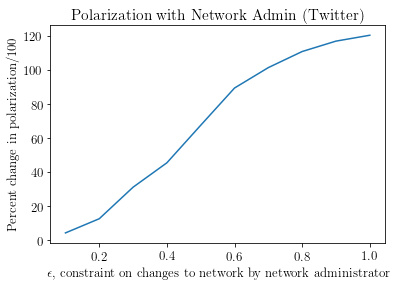

In [294]:
lamvals=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    pls = rd[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,pls_ratio_list - 1)
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization/100')
plt.title('Polarization with Network Admin (Twitter)')

plt.savefig('polarization_twitter.pdf')

# large increase in polarization - though not nearly as large as in Reddit :) 

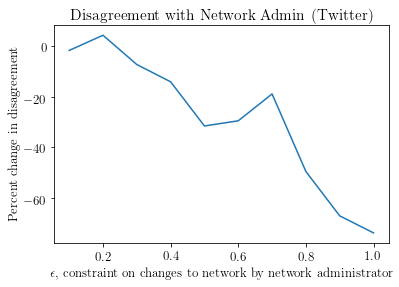

In [295]:
lamvals=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    dis = rd[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list - 1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title('Disagreement with Network Admin (Twitter)')

plt.savefig('disagreement_twitter.pdf')

# wow, disagreement increases a lot too!
#　→なんでincrease????

#### Plot polarization, disagreement with regularization

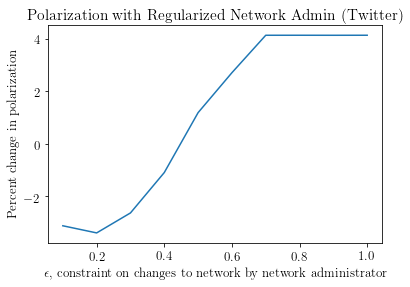

In [296]:
# same plots, but with network fix
lamvals=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

pls_after_list=np.zeros(len(lamvals))
pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    if lam <= 0.5:
        pls = rd_fix[lam][0]
    else:
        pls = rd_fix_large[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    pls_after_list[i] = pls[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(pls_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization')
plt.title('Polarization with Regularized Network Admin (Twitter)')
    
plt.savefig('polarization_twitter_fix.pdf')

# polarization is mostly neutral (even slightly dips at lambda=0.2,0.3)

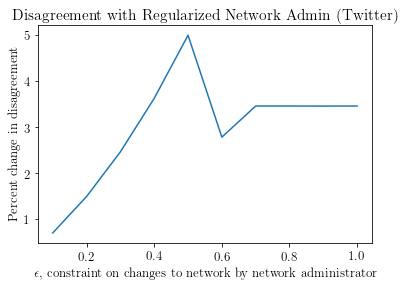

In [297]:
lamvals=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    if lam <= 0.5:
        dis = rd_fix[lam][1]
    else:
        dis = rd_fix_large[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title('Disagreement with Regularized Network Admin (Twitter)')

# fix the y axis from being weird
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)

plt.savefig('disagreement_twitter_fix.pdf')

# okay, so disagreement more-or-less stays the same!